In [1]:
import numpy as np; import matplotlib.pyplot as plt
import pymc3 as pm; from scipy import stats; import pandas as pd ;import os 
import theano; import seaborn as sns; from theano import shared, tensor as tt
# Age, Age Error, 40Ar, 39Ar, 37Ar, 36Ar, Temperature
cwd = os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv("mix_hb_acs.csv", engine = 'python')


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)


def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5

    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma

    return floatX(tau), floatX(sigma)


class Sum_of_Squares(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu

        return bound(-(value - mu)**2 + tt.log(2*tau)/ 2.,
                     sigma > 0)


In [3]:
temp = df['Temperature (Degrees Celcius)'].values
age = df['Age'].values
age_err = df['Age Error'].values
ar39 = df['39Ar'].values
ar39_Err = df['39Ar_Err'].values

In [5]:
age

array([12.33, 12.87, 12.95, 12.83, 12.92, 12.84, 12.81, 12.9 , 12.74,
       12.69, 12.56, 12.51, 12.21, 11.48, 10.58,  9.45,  8.  ,  6.38,
        4.66,  3.63,  2.99,  2.72,  2.63,  2.53,  2.39,  2.38,  2.4 ,
        2.4 ,  2.38,  2.54,  2.53,  2.28,  2.2 ,  2.16,  2.2 ,  2.05,
        1.89,  1.71,  1.42,  1.25,  1.36,  1.38,  1.62])

In [4]:
def frel(a): 
    y = np.cumsum(a)
    z = y/y.max()
    return z

In [ ]:
ww = frel(ar39)

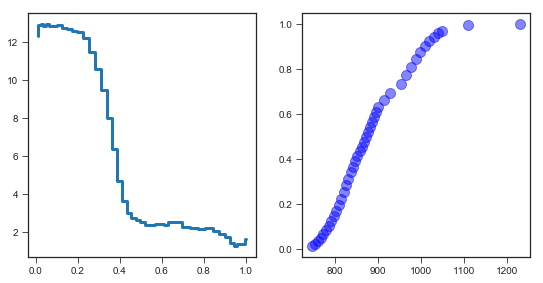

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].plot(ww, age, 
        drawstyle = 'steps', 
          lw = 3)
ax[1].plot(temp, ww, 'or', 
          color = 'blue', alpha = .48, markersize = 10)

## Testing the simplifying assumption of spherical goemetry with comparison to infinite sheet for the Biotite component

In [ ]:
def Incre_sheet(ea, d0, a, temp, t): 
    R = 8.314e-3
    D = d0*np.exp(-ea/(R*temp))
    q1 = (2/np.sqrt(np.pi))*(D*t/a**2)**0.5
    
    dq1 = (ea * ((D*t)/a**2)**0.5)/(np.sqrt(np.pi) * R * temp**2)
    
    dq2 = (2*d0*ea*t * np.exp((-np.pi**2 * D * t)/(4*a**2) - ea/(R*temp)))/(a**2 * R * temp**2)
    
    z = tt.switch(q1 < 0.6, dq1, dq2)
    
    return z


def frac_sheet(ea, d0, a, temp, t): 
    
    R = 8.314e-3
    D = d0*np.exp(-ea/(R*temp))
    
    q1 = (2/np.sqrt(np.pi))*(D*t/a**2)**0.5
    
    q2 = 1 - (8/(np.pi **2))*np.exp(- (np.pi**2) * ((D * t)/(4*a**2)))
    
    z = tt.switch(q1 < 0.6, q1, q2)
    
    return z

# Model

- In this model we will assess the assumption of spherical geometery
- By describing the biotite as an infinite sheet 

In [ ]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T



def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

# Arrhenius and Age Spectra Inversion 

In [ ]:
ww = frel(ar39)
R = 8.314e-3
tk = temp + 273.15
time = 300*np.ones(len(tk))
a_err = shared(age_err)
N = age.shape[0]
data3 = ww
data1 = age

In [ ]:
data3 = ww
data1 = age
W = pm.Model() 
M = 6
import pymc3.distributions.transforms as tr
with W:   
    """
    Mixing Fraction
    """ 
    phi = pm.Dirichlet('phi', a = np.array([0.25,0.75]),
                      shape = 2, 
                      testval = (0.25, 0.75))
    

    """
    Diffusion Kinetics
    """
    
    ea1 = pm.Normal('ea1',
                    mu = 196,
                    sd = 16)
    
    ea2 = pm.Normal('ea2', 
                    mu = 220,
                    sd = 9)
    
    lnd01 = pm.Normal('lnd01', mu = -2.6, sd = 1.9)
    
    
    lnd02 = pm.Normal('lnd02', mu = 8.4,
                      sd = 1)
    
    d01 = pm.Deterministic('d01', np.exp(lnd01))
    
    d02 = pm.Deterministic('d02',np.exp(lnd02) * (0.02**2))
    

    
    """
    Effective Diffusion lengthscale
    """
    a1 = pm.Uniform('a1',
                    lower = 0.001, 
                    upper = 0.0032)
    
    a2 = pm.Uniform('a2',
                    lower = 0.001, 
                    upper = 0.0032)

INFO (theano.gof.compilelock): Waiting for existing lock by process '16256' (I am process '17275')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jackcarter/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.6.8-64/lock_dir


In [ ]:
with W: 
    
    age1 = pm.Uniform('age1', lower = 0.0, upper= 4600, 
                             testval = 50)
    
    age2 = pm.Uniform('age2',lower = 0.0, upper= 4600, 
                             testval = 20)
    
    

In [ ]:
with W:
    # Mixture weights
    w1 = phi[0]
    w2 = phi[1]
    
    """
    Cumulative Release Models
    """
    A = frac_sheet(ea1, d01, a1, tk, time)
    B = fracrelx(ea2, d02, a2, tk, time)
    A = pm.Deterministic('A', A)
    B = pm.Deterministic('B', B)
    #Model
    mu1 = w1*A + w2*B
 ############################################################################
    # Add Monontonic Constraints to all fractional release 
    for i in range(len(tk) - 1): 
        fracrel_cons = pm.Potential(f'frel_cons{i}', 
                                       tt.switch(A[i + 1] - A[i] < 0, 
                                                 -np.inf, 0) + 
                                       tt.switch(B[i + 1] - B[i] < 0, 
                                                -np.inf, 0)) 
        
    # Add Monontonic Constraints to all fractional release 
    for i in range(len(tk) - 1): 
        fracrel_cons = pm.Potential(f'frel_consbb{i}', 
                                       tt.switch(mu1[i + 1] - mu1[i] < 0, 
                                                 -np.inf, 0) + 
                                   tt.switch(mu1.max() > 1, -np.inf, 0))
###########################################################################
    # Model 
    model1 = pm.Deterministic('model1', mu1)
    
    
    
    f_err1 = pm.HalfNormal('f_err1', 
                           sd = 0.1, 
                          shape = N)
    

In [ ]:
with W: 

    X = Incre_sheet(ea1, d01, a1, tk, time)
    Y = Increment(ea2, d02, a2, tk, time)
    
    YY = pm.Deterministic('YY', Y)
    XX = pm.Deterministic('XX', X)
    
    #Model    
    mu2 = ((w1*X)/(w1*X + w2*Y))*age1 + ((w2*Y)/(w1*X + w2*Y))*age2
    
    # Model Trace
    model2 = pm.Deterministic('model2', mu2)
    
    age_model_err = pm.HalfNormal('age_model_err', sd = 2, 
                                 shape = N)

In [ ]:
def logp(mod, data, err): 
    logp = -0.5*tt.sum((((data - mod)/err)**2))
    return logp

In [ ]:
with W: 
    #Fractional Release
    obs1 = pm.Normal('obs1', mu = mu1, sd = f_err1, 
                        observed = data3)

    # Age    
    obs2 = Sum_of_Squares('obs2', mu2, age_model_err, 
                         observed= data1)

In [ ]:
W.check_test_point()

a1_interval__             -1.39
a2_interval__             -1.39
age1_interval__           -4.86
age2_interval__           -5.78
age_model_err_log__      -33.11
ea1                       -3.69
ea2                       -3.12
f_err1_log__             -33.11
lnd01                     -1.56
lnd02                     -0.92
obs1                     -39.96
obs2                  -16861.21
phi_stickbreaking__       -2.05
Name: Log-probability of test_point, dtype: float64

In [ ]:
SAMPLES = 100000
BURN = 200000
with W: 
    # Compound Steps
    step1 = pm.NUTS([phi, 
                     ea1, ea2,
                     d01, d02,
                     f_err1], 
                   target_accept = 0.83, 
                   max_treedepth = 14)
    
    step2 = pm.Metropolis([a1, a2, 
                          age1, age2, 
                          age_model_err])
    
    # Steps
    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = pm.Metropolis(), 
                     cores = 2)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [age_model_err]
>Metropolis: [f_err1]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [lnd02]
>Metropolis: [lnd01]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi]
Sampling 2 chains:   3%|▎         | 19390/600000 [02:23<1:12:44, 133.04draws/s]

In [121]:
with W:
    ppc = pm.sample_ppc(trace[-10000:], 5000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 5000/5000 [00:40<00:00, 122.35it/s]


# Models

In [122]:
zz1 = ppc['obs1'].mean(axis = 0)
zz2 = ppc['obs2'].mean(axis = 0)

# 95% Model Credible Intervals 

In [123]:
f_low, f_high = np.percentile(ppc['obs1'],
                              [2.5, 97.5],
                              axis = 0)

age_mod_low, age_mod_high = np.percentile(ppc['obs2'], 
                                         [2.5, 97.5], 
                                         axis = 0)



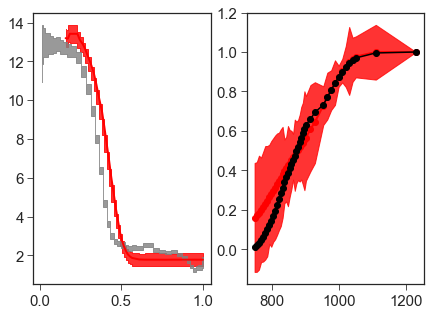

In [124]:
fig, ax = plt.subplots(1, 2, figsize = (7, 5))

ax[0].fill_between(zz1, age_mod_low, 
                  age_mod_high, 
                  step = 'pre',  
                  alpha = 0.8, 
                  color = 'r', 
                  label = '95% Credible\nInterval')

ax[0].plot(zz1, zz2, 'r-', 
          lw = 2, 
          label = 'Mean\nPosterior\nModel')


ax[0].fill_between(ww, age + age_err, age - age_err, 
        step = 'pre', alpha = 0.8, color = 'grey',
          edgecolor = 'k')


ax[1].fill_between(temp, f_low, f_high, 
                  color = 'r', alpha = 0.8)

ax[1].plot(temp, zz1, '-or', 
          lw = 2, label = 'Mean\nPosterior\nModel')
ax[1].plot(temp, ww, '-ok', 
          label = 'Data')



# DataFrames for plotting

1. DataFrame of data and mean posterior models and 95% Credibel intervals

In [125]:
# Data frame for mean posterior model 

df1 = pd.DataFrame({"model_age": zz2, 
                   "model_age_low": age_mod_low, 
                   "model_age_high":age_mod_high, 
                   "frel_mod": zz1, 
                   "frel_mod_low": f_low, 
                   "frel_mod_low": f_high, 
                   "age_data" : age, 
                   "age_data_err": age_err,
                   "frel_data": ww, 
                   "temp": temp})

In [126]:
# DataFrame for trace
# PairPlot dataframe
df2 = pm.trace_to_dataframe(trace[::5])

In [127]:
df2.to_csv('hb_acs1_infinitesheet_trace.csv')
df1.to_csv('hb_acs1_infinitesheet_post.csv')

In [128]:
# SHeet plotting 
f_mod_plot = np.insert(zz1, 0, 0)
f_data_plot2  = np.insert(ww, 0, 0)

age_data2_plot = np.insert(age, 0, age[0])
age_err2_plot = np.insert(age_err, 0, age_err[0])

age_model2_plot = np.insert(zz2, 0, zz2[0])
age_low_plot = np.insert(age_mod_low, 0, age_mod_low[0])
age_high_plot = np.insert(age_mod_high, 0, age_mod_high[0])

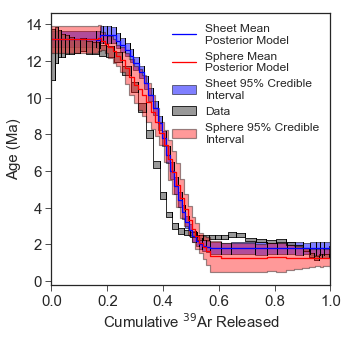

In [129]:
sns.set_style('ticks')
font = {"family": "Arial", 
       "weight": "normal", 
       "size": 15}

plt.rc("font", **font)

plt.figure(figsize = (5,5))
plt.fill_between(f_mod_plot, age_low_plot, 
                  age_high_plot, 
                  step = 'pre',  
                  alpha = 0.5, 
                  facecolor = 'b', 
                  label = 'Sheet 95% Credible\nInterval', 
                  edgecolor = 'k')

plt.plot(f_mod_plot, age_model2_plot, 'b-', 
          lw = 1.3, 
          drawstyle = 'steps', 
        label = 'Sheet Mean\nPosterior Model')


plt.fill_between(f_data_plot2, age_data2_plot + age_err2_plot,
                   age_data2_plot - age_err2_plot, 
        step = 'pre', alpha = 0.8, facecolor = 'grey',
          edgecolor = 'k', 
                  label = 'Data')

for i in range(len(age_data2_plot)): 
    plt.vlines(f_mod_plot, age_low_plot, 
                  age_high_plot, color = 'k', lw= 0.7)

for i in range(len(age_data2_plot)): 
    plt.vlines(f_data_plot2, age_data2_plot + age_err2_plot,
                   age_data2_plot - age_err2_plot,
               color = 'k', lw= 0.7)

plt.fill_between(ha_fmp, ha_alow, ha_ahigh, 
                    edgecolor = 'k', 
                    facecolor = 'r', 
                    step = 'pre', 
                    lw = 1.2, 
                    label = 'Sphere 95% Credible\nInterval', 
                alpha = 0.4)
plt.plot(ha_fmp, ha_am, lw = 1.3, color = 'r', 
        drawstyle = 'steps', 
        label = 'Sphere Mean\nPosterior Model')


plt.xlabel('Cumulative $^{39}$Ar Released')
plt.ylabel('Age (Ma)')
plt.legend(fontsize = 12)
plt.xlim(0,1)
plt.savefig('sphere_vs_sheet_hb_acs.pdf')

In [130]:
df_ta = pd.read_csv('hb_acs_age_plot.csv')

In [131]:
ha_am = df_ta['age_m'].values
ha_alow = df_ta['age_low'].values
ha_ahigh = df_ta['age_high'].values
ha_fmp = df_ta['frel_plot'].values
ha_data = df_ta['data'].values
ha_data_err = df_ta['data_err'].values
ha_frel_data = df_ta['f_data_plot'].values